### Env Setting

In [95]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import statsmodels as sm
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, ccf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics import utils
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

### Loading Taxi dataset

In [46]:
yellow = pd.read_csv("../Data/Taxi_Data/full_yellow.csv", index_col=0)
green = pd.read_csv("../Data/Taxi_Data/full_green.csv", index_col=0)
fhv = pd.read_csv("../Data/Taxi_Data/full_fhv.csv", index_col=0)
hvfhv = pd.read_csv("../Data/Taxi_Data/full_hvfhv.csv", index_col=0)
trad_taxi = yellow.append(green)
app_taxi = fhv.append(hvfhv)
total_taxi = trad_taxi.append(app_taxi)

In [47]:
yellow.index = pd.to_datetime(yellow.index)
green.index = pd.to_datetime(green.index)
fhv.index = pd.to_datetime(fhv.index)
hvfhv.index = pd.to_datetime(hvfhv.index)
trad_taxi.index = pd.to_datetime(trad_taxi.index)
app_taxi.index = pd.to_datetime(app_taxi.index)
total_taxi.index = pd.to_datetime(total_taxi.index)

### Plotting - Raw Data

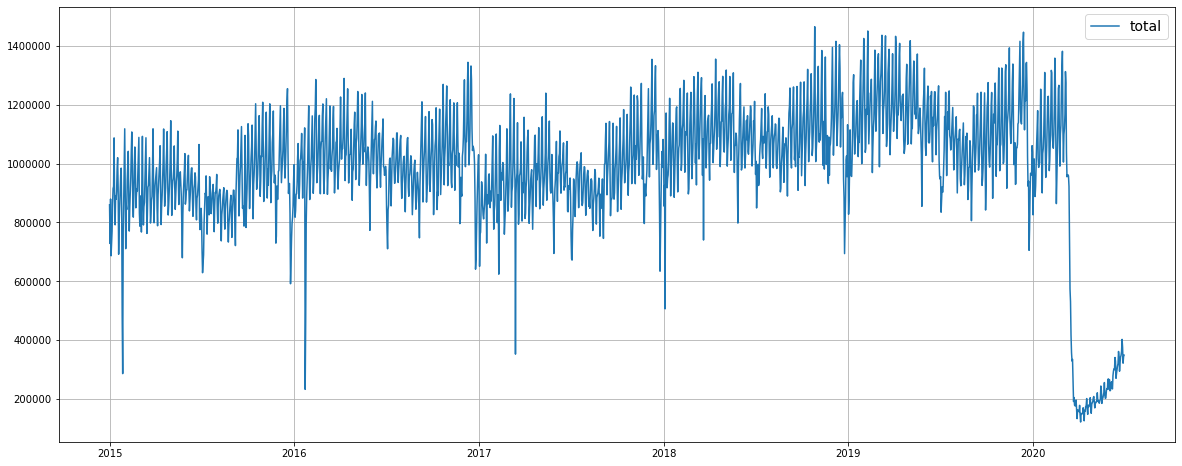

In [48]:
################################################
# 'individual': yellow / green / fhv / hvfhv
# 'twoGroup':   yellow + green / fhv + hvfhv
# 'total':      yellow + green + fhv + hvfhv
################################################
plot_type = 'total'    

plt.figure(figsize=(20,8))
if plot_type == 'individual': 
    plt.plot(yellow['passenger_count'].groupby(yellow.index).sum(), label="yellow")
    plt.plot(green['passenger_count'].groupby(green.index).sum(), label="green")
    plt.plot(fhv['passenger_count'].groupby(fhv.index).sum(), label="fhv")
    plt.plot(hvfhv['passenger_count'].groupby(hvfhv.index).sum(), label="hvfhv")
elif plot_type == 'twoGroup':
    plt.plot(trad_taxi['passenger_count'].groupby(trad_taxi.index).sum(), label="yellow + green", c="darkorange")
    plt.plot(app_taxi['passenger_count'].groupby(app_taxi.index).sum(), label="fhv (including high volume)")
elif plot_type == 'total':
    plt.plot(total_taxi['passenger_count'].groupby(total_taxi.index).sum(), label="total")

plt.legend(fontsize=14)
plt.grid()
plt.show()

### Split into preCovid_training / preCovid_test / postCovid

In [49]:
# preCovid // postCovid
total = total_taxi['passenger_count'].groupby(total_taxi.index).sum()
covidOutbreak = '2020-03-01'
preCovid = total.loc[:covidOutbreak]
postCovid = total.loc[covidOutbreak:]

In [50]:
# training // test 
trainCutoff = '2019-01-01'
train = preCovid[:trainCutoff]
test = preCovid[trainCutoff:]

### Plotting ACF, PACF

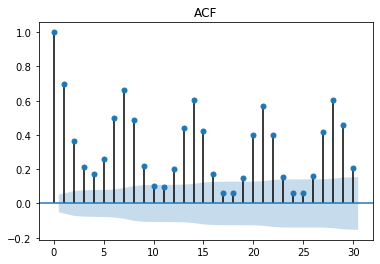

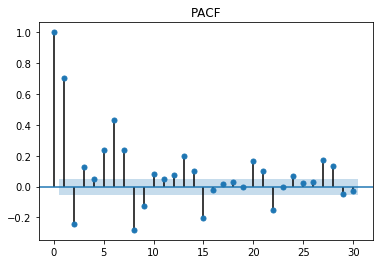

In [51]:
lag = len(train) -1
plot_acf(x=train, lags=30, title='ACF')  ## ACF plots shows strong seasonality
plt.show()
plot_pacf(x=train, lags=30, title='PACF')
plt.show()

### Seasonal Decomposition

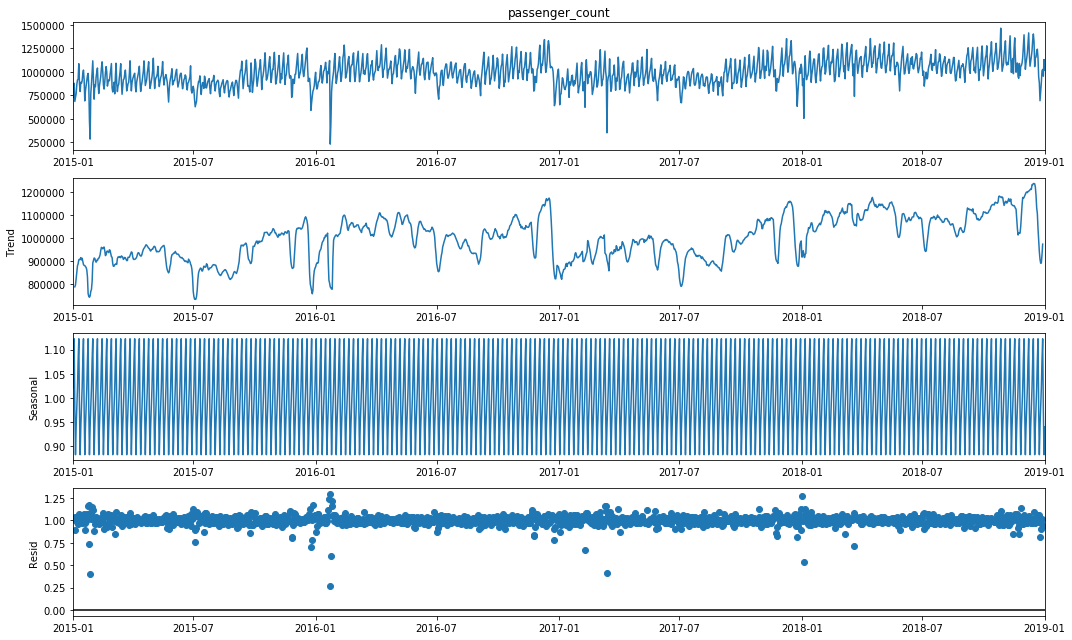

In [67]:
# https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
from pylab import rcParams
rcParams['figure.figsize'] = 15, 9
train_decompose = seasonal_decompose(train, model='multiplicative')
train_decompose.plot()
plt.show()

In [78]:
pd.DataFrame({"observed": train_decompose.observed, "trend": train_decompose.trend, "seasonal": train_decompose.seasonal, \
              "resid": train_decompose.resid, "multiplied": train_decompose.trend*train_decompose.seasonal*train_decompose.resid})

,observed,trend,seasonal,resid,multiplied
pickup_datetime,,,,,
2015-01-01,860105.0,NaN,1.020357,NaN,NaN
2015-01-02,728493.0,NaN,1.078117,NaN,NaN
2015-01-03,879888.0,NaN,1.122439,NaN,NaN
2015-01-04,686645.0,788645.142857,0.975904,0.892161,686645.0
2015-01-05,729239.0,796547.428571,0.882307,1.037620,729239.0
...,...,...,...,...,...
2018-12-28,1012322.0,927894.428571,1.078117,1.011938,1012322.0
2018-12-29,1026569.0,974400.142857,1.122439,0.938616,1026569.0
2018-12-30,955648.0,NaN,0.975904,NaN,NaN


In [85]:
train_resid = train_decompose.resid

### Normalization

In [ ]:
scaler = StandardScaler()
scaler.fit(train_resid.values.reshape(-1,1))
train = scaler.transform(train_resid.values.reshape(-1,1))
test = scaler.transform(test.values.reshape(-1,1))

### Fitting ARIMA

In [122]:
import warnings
warnings.filterwarnings("ignore")
mse_list = []
for i in range(10):
    arima = ARIMA(train_resid[3:-3], order=(i,0,0), freq='D')
    arima_res = arima.fit()
    mse_list.append(mean_squared_error(train_resid[3:-3], arima_res.fittedvalues))
    print(f'>>> p = {i}, mean_squared_error: {mean_squared_error(train_resid[3:-3], arima_res.fittedvalues)}')

>>> p = 0, mean_squared_error: 0.0034366247304000582
>>> p = 1, mean_squared_error: 0.0033180809171701998
>>> p = 2, mean_squared_error: 0.002956121428471556
>>> p = 3, mean_squared_error: 0.0027054390988273318
>>> p = 4, mean_squared_error: 0.002646097451898103
>>> p = 5, mean_squared_error: 0.0025224141422985893
>>> p = 6, mean_squared_error: 0.002449766971682271
>>> p = 7, mean_squared_error: 0.002425737818882949
>>> p = 8, mean_squared_error: 0.0024154617696510827
>>> p = 9, mean_squared_error: 0.0023725254761646332


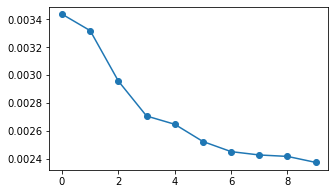

Plateau around p=6


In [133]:
plt.figure(figsize=(5,3))
plt.plot(mse_list, marker='o')
plt.show()
print("Plateau around p=6")

In [134]:
ma_mse_list = []
for i in range(10):
    arima = ARIMA(train_resid[3:-3], order=(6,0,i), freq='D')
    arima_res = arima.fit()
    ma_mse_list.append(mean_squared_error(train_resid[3:-3], arima_res.fittedvalues))
    print(f'>>> q = {i}, mean_squared_error: {mean_squared_error(train_resid[3:-3], arima_res.fittedvalues)}')

>>> q = 0, mean_squared_error: 0.002449766971682271
>>> q = 1, mean_squared_error: 0.002285398595223394
>>> q = 2, mean_squared_error: 0.0022876678208053817
>>> q = 3, mean_squared_error: 0.0023670345308823538
>>> q = 4, mean_squared_error: 0.002291245652687717
>>> q = 5, mean_squared_error: 0.0022786247357742748
>>> q = 6, mean_squared_error: 0.0022796100152046705
>>> q = 7, mean_squared_error: 0.002291175319847431
>>> q = 8, mean_squared_error: 0.0022719565374279545
>>> q = 9, mean_squared_error: 0.002269622552647357


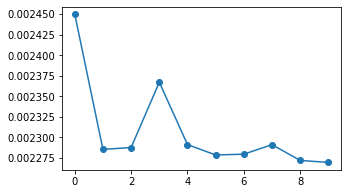

Plateau around p=1


In [136]:
plt.figure(figsize=(5,3))
plt.plot(ma_mse_list, marker='o')
plt.show()
print("Plateau around p=1")

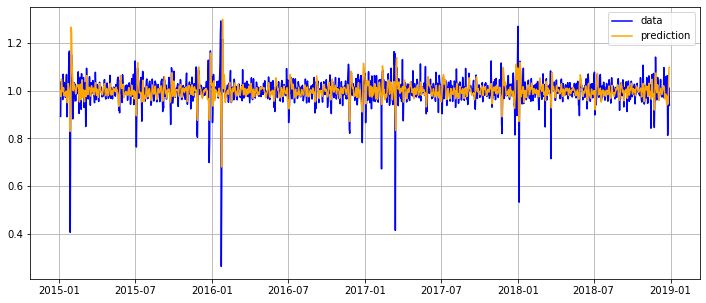

>>> mean_squared_error: 0.002341623306426204


In [137]:
arima = ARIMA(train_resid[3:-3], order=(7,0,1), freq='D')
arima_res = arima.fit()
plt.figure(figsize=(12,5))
plt.plot(train_resid, color='blue', label="data")
plt.plot(arima_res.fittedvalues, color='orange', label="prediction")
plt.legend()
plt.grid()
plt.show()
print(f'>>> mean_squared_error: {mean_squared_error(train_resid[3:-3], arima_res.fittedvalues)}')

In [149]:
pred = arima_res.predict(start='2019-01-01', end='2020-02-29')[3:-2]
pred

2019-01-04    0.956549
2019-01-05    0.977027
2019-01-06    0.993756
2019-01-07    1.003333
2019-01-08    1.010158
                ...   
2020-02-23    0.999599
2020-02-24    0.999599
2020-02-25    0.999599
2020-02-26    0.999599
2020-02-27    0.999599
Freq: D, Name: predicted_mean, Length: 420, dtype: float64

In [150]:
test_decompose = seasonal_decompose(test, model='multiplicative')
true = test_decompose.resid[3:-3]
true

pickup_datetime
2019-01-04    0.935007
2019-01-05    1.033968
2019-01-06    1.033444
2019-01-07    1.058230
2019-01-08    0.960848
                ...   
2020-02-23    0.971597
2020-02-24    0.970335
2020-02-25    1.011875
2020-02-26    0.985545
2020-02-27    1.029375
Name: resid, Length: 420, dtype: float64

In [151]:
mean_squared_error(true, pred)

0.0017303615778294745

### Kalman Filtering

In [107]:
from pykalman import KalmanFilter
import numpy as np

In [108]:
def plot_kalman(time, latent, data, ky=None, ky_var=None, plot_type="r-", label=None, title='sample'):
    """
    Plot the trajectory
    """
    x, y = time, latent
    nx, ny = data[:, 0], data[:, 1]
    fig, ax = plt.subplots(1, 2, figsize=(18, 4))
    if ky is not None:
        ax[0].plot(x, y, 'g-', time, nx, 'b.', time, ny, 'b.', time, ky, 'r-', plot_type)
        if ky_var is not None:
            ax[0].fill_between(time, ky - np.sqrt(ky_var),
                               ky + np.sqrt(ky_var), color='r', alpha=.5, label='estimate')
        ax[0].legend()
        ax[1].plot(y, ky, '.', color='grey')
        ax[1].set_xlabel('real latent')
        ax[1].set_ylabel('estimated latent')
        ax[1].set_title('cc %.3f' %(np.corrcoef(y[:,0], ky)[0,1]))
    else:
        ax[0].plot(x, y, 'g-', x, nx, 'b.', x, ny, 'b.')

        ax[1].plot(y, nx, '.k', label='observed dim 1')
        ax[1].plot(y, ny, '.', color='grey', label='observed dim 2')
        ax[1].set_xlabel('latent')
        ax[1].set_ylabel('observed')
        ax[1].legend()

    ax[0].set_xlabel('time')
    ax[0].set_ylabel('latent')
    ax[0].set_title(title)
    ax[1].set_aspect(1)

    return fig

In [109]:
total_daily = total_taxi.groupby('pickup_datetime').sum()['passenger_count']

In [110]:
preCovid = total_daily[:'2020-03-01']
postCovid = total_daily['2020-03-01':]

In [111]:
de_preCovid = sm.tsa.tsatools.detrend(preCovid)
de_postCovid = sm.tsa.tsatools.detrend(postCovid)
de_allPeriod = sm.tsa.tsatools.detrend(total_daily)

In [112]:
n_dim_state = 1
n_dim_obs = 1
kf_daily = KalmanFilter(n_dim_state=n_dim_state, n_dim_obs=n_dim_obs, 
                  transition_matrices = np.eye(n_dim_state)*.9, 
                  transition_covariance = np.eye(n_dim_state)*10, 
                  observation_matrices = np.random.randn(n_dim_state*n_dim_obs).reshape(n_dim_obs, n_dim_state),
                  observation_covariance = np.eye(n_dim_obs)*10,
                  initial_state_mean = np.zeros(n_dim_state), 
                  initial_state_covariance = np.eye(n_dim_state))
kf_daily = kf_daily.em(de_allPeriod, n_iter=5)

In [113]:
filtered_mean, filtered_cov = kf_daily.filter(de_allPeriod)
smoothed_mean, smoothed_cov = kf_daily.smooth(de_allPeriod)

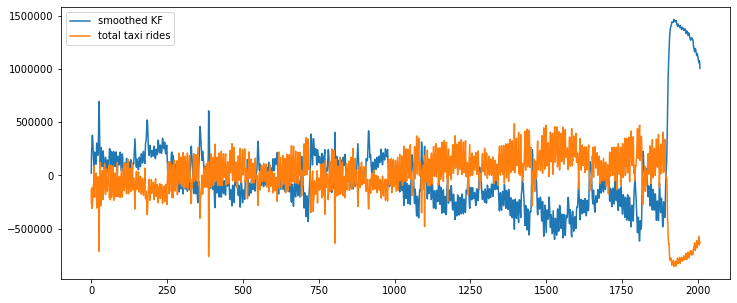

In [114]:
plt.figure(figsize=(12,5))
plt.plot(smoothed_mean, label="smoothed KF")
# plt.plot(filtered_mean, label="filtered KF")
plt.plot(de_allPeriod.values, label="total taxi rides")
plt.legend()
plt.show()

In [115]:
total_taxi_monthly = total_taxi.groupby(pd.Grouper(freq="M")).sum()['passenger_count']

In [116]:
preCovid_monthly = total_taxi_monthly[:'2020-03-01']
postCovid_monthly = total_taxi_monthly['2020-03-01':]

In [117]:
de_preCovid_monthly = sm.tsa.tsatools.detrend(preCovid_monthly)
de_postCovid_monthly = sm.tsa.tsatools.detrend(postCovid_monthly)
de_allPeriod_monthly = sm.tsa.tsatools.detrend(total_taxi_monthly)

In [118]:
n_dim_state = 1
n_dim_obs = 1
kf_monthly = KalmanFilter(n_dim_state=n_dim_state, n_dim_obs=n_dim_obs, 
                  transition_matrices = np.eye(n_dim_state)*.9, 
                  transition_covariance = np.eye(n_dim_state)*10, 
                  observation_matrices = np.random.randn(n_dim_state*n_dim_obs).reshape(n_dim_obs, n_dim_state),
                  observation_covariance = np.eye(n_dim_obs)*10,
                  initial_state_mean = np.zeros(n_dim_state), 
                  initial_state_covariance = np.eye(n_dim_state))
kf_monthly = kf_monthly.em(de_allPeriod_monthly, n_iter=5)

In [119]:
filtered_mean, filtered_cov = kf_monthly.filter(de_allPeriod_monthly)
smoothed_mean, smoothed_cov = kf_monthly.smooth(de_allPeriod_monthly)

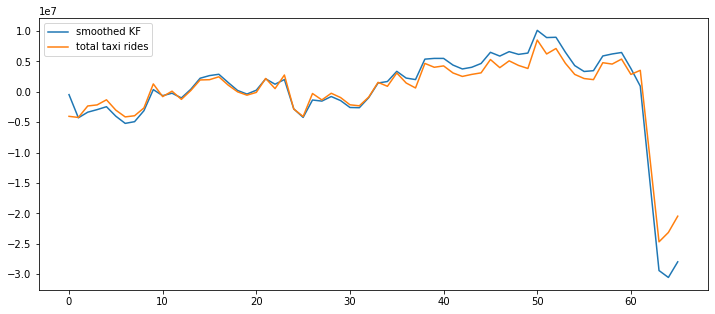

In [121]:
plt.figure(figsize=(12,5))
plt.plot(smoothed_mean, label="smoothed KF")
# plt.plot(filtered_mean, label="filtered KF")
plt.plot(de_allPeriod_monthly.values, label="total taxi rides")
plt.legend()
plt.show()

In [ ]:
# mse

def MSE(pred):
    val = pre_val['daily_counts_std']
    MSE = np.mean((val-pred)**2)
    return MSE

In [ ]:
# scikit-learn: standardscaler
# precovid: 2015-01-01 ~ 2018-12-31: training
#           2019-01-01 - 2020-03-01(exclusive): validation
# postCovid: 